PARTIAL CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in partial df: 1067
Rows that have all features = NaN: 21
TRAIN rows: 938
VAL   rows: 108
TEST  rows: 21
Current device: cuda

=== Training & Predicting with ARIMA, plus Additional Diagrams ===
[ARIMA] ARIMA baseline model created.

COMPLETE CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in complete df: 1067


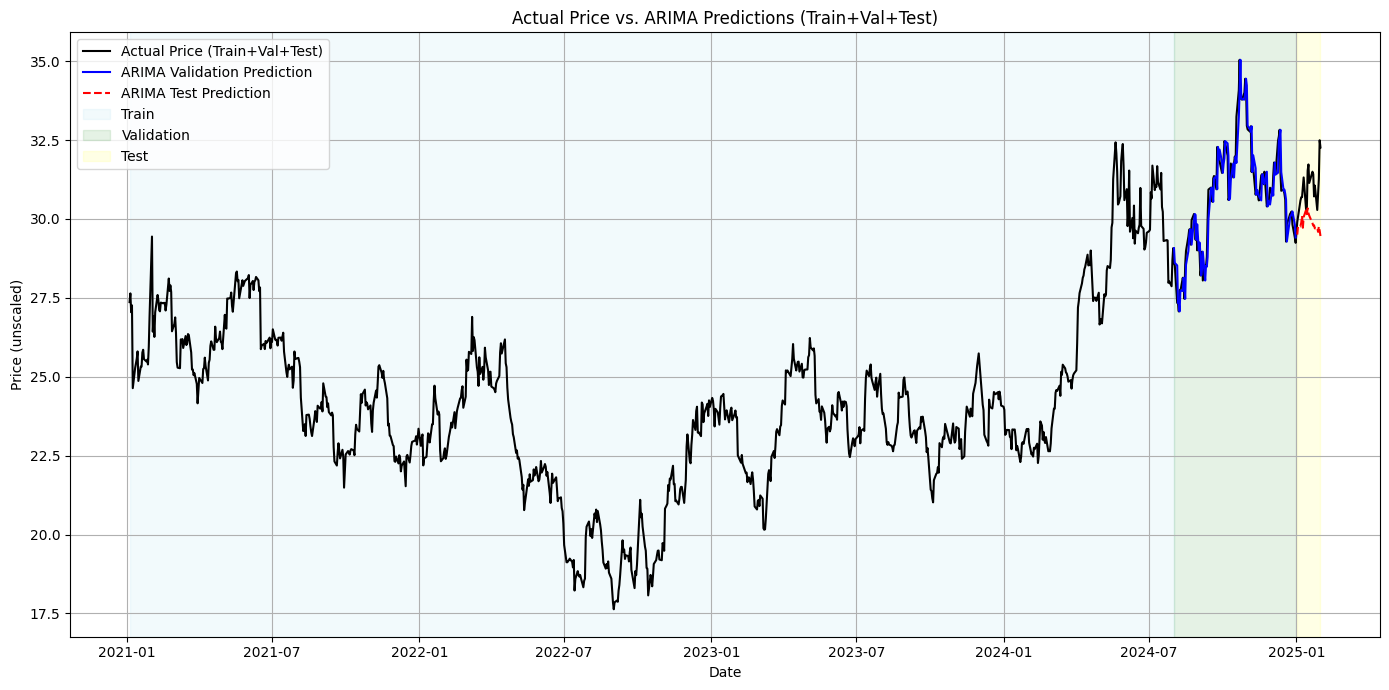

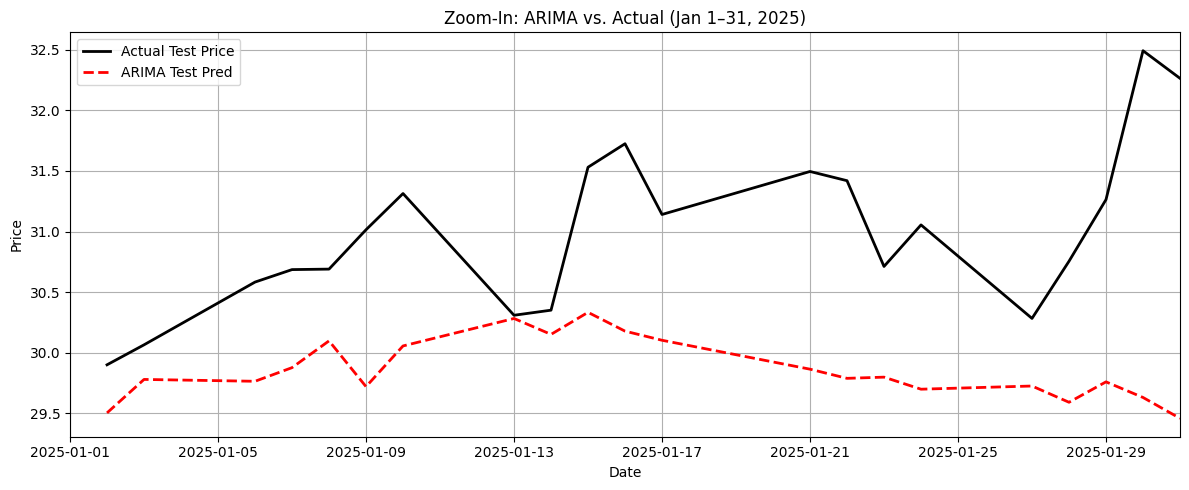

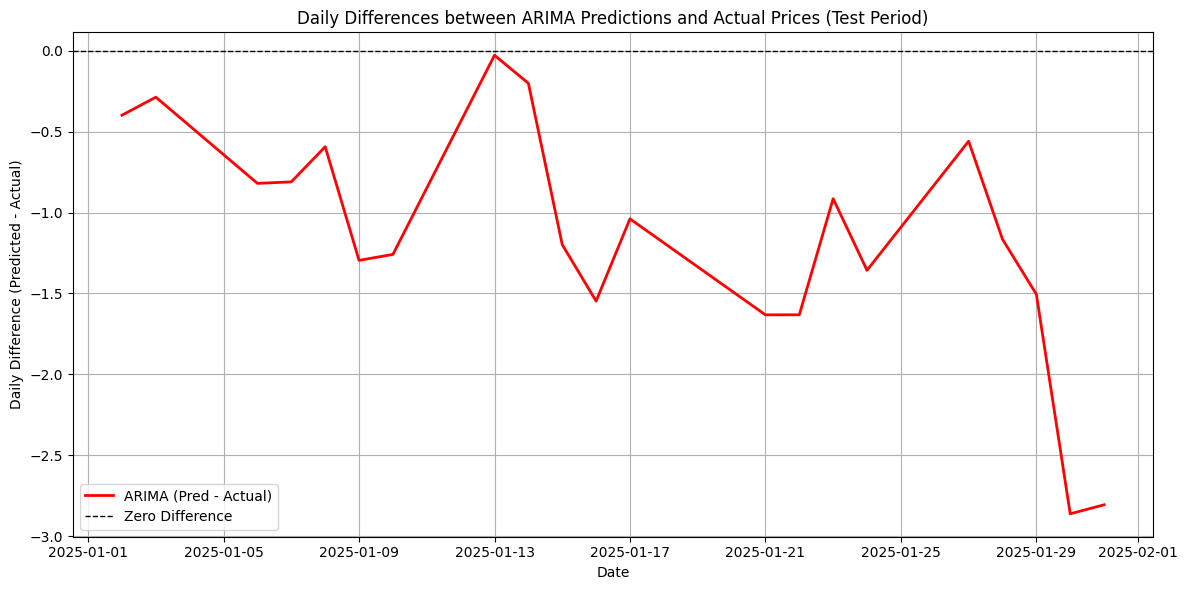

Actual: Best polynomial degree = 33, Validation MSE = 0.1965
  Polynomial: y = 3.13e-130*x^33+5.73e-127*x^32-5.29e-122*x^31-1.62e-117*x^30-3.3e-113*x^29-5.33e-109*x^28-6.48e-105*x^27-3.87e-101*x^26+1.11e-96*x^25+5.37e-92*x^24+1.54e-87*x^23+3.59e-83*x^22+7.37e-79*x^21+1.35e-74*x^20+2.19e-70*x^19+2.84e-66*x^18+1.82e-62*x^17-3.92e-58*x^16-2.28e-53*x^15-7.08e-49*x^14-1.78e-44*x^13-3.95e-40*x^12-7.75e-36*x^11-1.36e-31*x^10-1.89e-27*x^9-1.65e-23*x^8+1.98e-19*x^7+1.54e-14*x^6+5.08e-10*x^5+1.26e-05*x^4+0.25*x^3+3.31e+03*x^2-1.43e+07*x-3.19e+12
ARIMA: Best polynomial degree = 4, Validation MSE = 0.0255
  Polynomial: y = 2.85e-09*x^4-0.000115*x^3+0.000673*x^2+4.63e+04*x-4.66e+08


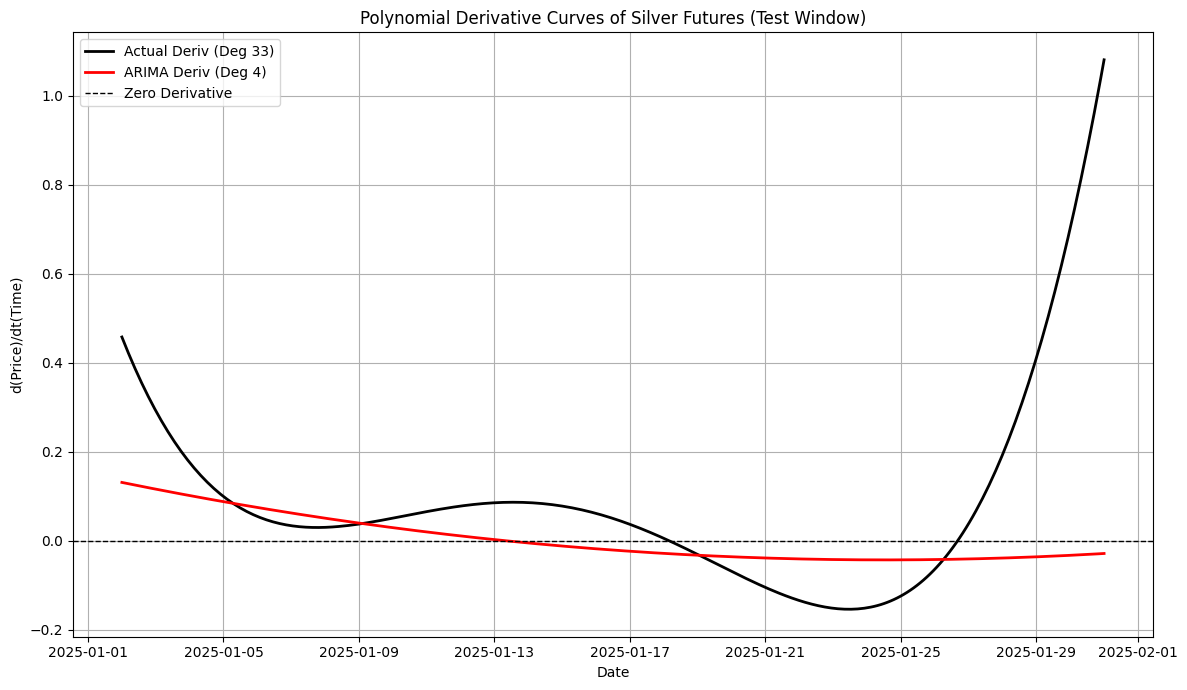


=== Polynomial Derivative Expressions ===
[Actual] (Deg 33) -> derivative: 1.03e-128*x^32+1.83e-125*x^31-1.64e-120*x^30-4.87e-116*x^29-9.58e-112*x^28-1.49e-107*x^27-1.75e-103*x^26-1.01e-99*x^25+2.77e-95*x^24+1.29e-90*x^23+3.55e-86*x^22+7.91e-82*x^21+1.55e-77*x^20+2.69e-73*x^19+4.16e-69*x^18+5.11e-65*x^17+3.09e-61*x^16-6.27e-57*x^15-3.43e-52*x^14-9.91e-48*x^13-2.32e-43*x^12-4.74e-39*x^11-8.52e-35*x^10-1.36e-30*x^9-1.7e-26*x^8-1.32e-22*x^7+1.39e-18*x^6+9.27e-14*x^5+2.54e-09*x^4+5.04e-05*x^3+0.751*x^2+6.61e+03*x-1.43e+07
[ARIMA] (Deg 4) -> derivative: 1.14e-08*x^3-0.000344*x^2+0.00135*x+4.63e+04

All tasks done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib
from statsmodels.tsa.arima.model import ARIMA
import torch.backends.cudnn as cudnn

###############################################################################
# 0. Suppress all warning messages
###############################################################################
warnings.filterwarnings("ignore")

# Let CuDNN pick the fastest algorithm for your hardware
cudnn.benchmark = True

###############################################################################
# 1. Set random seeds
###############################################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################################
# Global hyperparameters
###############################################################################
WINDOW_SIZE = 35
features = ["Price", "Open", "High", "Low"]

# (A) For training: partial CSV
csv_file_partial = "Silver Futures Historical Data.csv"

# (B) For final plotting + actual test data: complete CSV
csv_file_complete = "Silver Futures Historical Data_Complete.csv"

###############################################################################
# 2. Load & Clean the partial CSV (used for train/val/test)
###############################################################################
df = pd.read_csv(csv_file_partial)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("PARTIAL CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in partial df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

###############################################################################
# 3. Date cutoffs: TRAIN, VAL, TEST
###############################################################################
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

###############################################################################
# 5. Create Training Sequences (for pipeline consistency)
###############################################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)
X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=len(train_dataset),  # single-batch approach
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4
)

###############################################################################
# 6. ARIMA Baseline Model Definition
###############################################################################
class ARIMAModel(nn.Module):
    def __init__(self, order=(1,0,0), epsilon=1e-4):
        """
        ARIMA baseline model (univariate per feature).
        order: ARIMA order, e.g., (1,0,0) is AR(1).
        epsilon: threshold below which std is near-constant => fallback last value.
        """
        super().__init__()
        self.order = order
        self.epsilon = epsilon
        
    def forward(self, x):
        # x: shape (batch, window, features)
        batch_predictions = []
        for sample in x:
            sample_pred = []
            for feature_idx in range(sample.shape[1]):
                series = sample[:, feature_idx].detach().cpu().numpy()
                # If nearly constant => just return the last value
                if np.std(series) < self.epsilon:
                    forecast = series[-1]
                else:
                    try:
                        model = ARIMA(series, order=self.order)
                        model_fit = model.fit(disp=0)
                        forecast = model_fit.forecast(steps=1)[0]
                    except Exception:
                        # fallback if ARIMA fails
                        forecast = series[-1]
                sample_pred.append(forecast)
            batch_predictions.append(sample_pred)

        return torch.tensor(batch_predictions).float().to(x.device)

def train_model_arima():
    """
    Create the ARIMA-based model (no actual 'training loop' needed).
    """
    model = ARIMAModel(order=(1,0,0)).to(device)
    print("[ARIMA] ARIMA baseline model created.")
    return model

###############################################################################
# 7. Validation Predictions (non-iterative, half-blind)
###############################################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    # Inverse-scale
    scl_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 8. Iterative Walk-Forward Test Predictions + Noise
###############################################################################
def iterative_walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE, noise_std=0.01):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    test_idx = df_work.index[df_work["Date"] >= test_start]
    if len(test_idx) == 0:
        raise ValueError("No test data available after test_start.")
    first_test_idx = test_idx[0]

    # Start window from last 'window' days before test start
    current_window = df_work.iloc[first_test_idx - window:first_test_idx][features].values
    test_dates = np.sort(df_work.loc[df_work["Date"] >= test_start, "Date"].unique())

    preds = []
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]

            # Add random noise so ARIMA doesn't flatten out
            noise = np.random.normal(scale=noise_std, size=pred_scaled.shape)
            pred_scaled_noisy = pred_scaled + noise

            preds.append((d, *pred_scaled_noisy))
            # Overwrite the oldest row in the window with these predicted values
            current_window = np.vstack((current_window[1:], pred_scaled_noisy))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    # Inverse-scale
    scl_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################################
# 9A. Evaluate & Plot Full Timeline
###############################################################################
def evaluate_and_plot(val_pred_df, test_pred_df, complete_csv=csv_file_complete):
    """
    Overlays ARIMA val & test preds on the entire timeline from complete_csv.
    """
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    df_complete.reset_index(drop=True, inplace=True)
    print("\nCOMPLETE CSV date range:")
    print("  Min date:", df_complete["Date"].min())
    print("  Max date:", df_complete["Date"].max())
    print("Number of rows in complete df:", len(df_complete))

    plt.figure(figsize=(14,7))
    # Plot entire actual line
    plt.plot(df_complete["Date"], df_complete["Price"], color="black", label="Actual Price (Train+Val+Test)")

    # ARIMA val predictions
    if val_pred_df is not None and not val_pred_df.empty:
        plt.plot(val_pred_df["Date"], val_pred_df["Pred_Price_unscaled"],
                 color="blue", linestyle="-", label="ARIMA Validation Prediction")

    # ARIMA test predictions
    if test_pred_df is not None and not test_pred_df.empty:
        plt.plot(test_pred_df["Date"], test_pred_df["Pred_Price_unscaled"],
                 color="red", linestyle="--", label="ARIMA Test Prediction")

    # Shade train/val/test
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, df_complete["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Actual Price vs. ARIMA Predictions (Train+Val+Test)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 9B. Zoom in on Jan 1–31, 2025
###############################################################################
def plot_test_period_zoom(test_pred_df, complete_csv=csv_file_complete):
    start_zoom = pd.to_datetime("2025-01-01")
    end_zoom   = pd.to_datetime("2025-01-31")

    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    df_test_actual = df_complete[
        (df_complete["Date"] >= start_zoom) & (df_complete["Date"] <= end_zoom)
    ].copy()

    if test_pred_df is not None and not test_pred_df.empty:
        test_pred_df_zoom = test_pred_df[
            (test_pred_df["Date"] >= start_zoom) &
            (test_pred_df["Date"] <= end_zoom)
        ].copy()
    else:
        test_pred_df_zoom = pd.DataFrame()

    plt.figure(figsize=(12,5))

    # Actual test data line
    if not df_test_actual.empty:
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color="black", linewidth=2, label="Actual Test Price")

    # ARIMA predictions
    if not test_pred_df_zoom.empty:
        plt.plot(test_pred_df_zoom["Date"], test_pred_df_zoom["Pred_Price_unscaled"],
                 color="red", linestyle="--", linewidth=2, label="ARIMA Test Pred")

    plt.xlim([start_zoom, end_zoom])
    plt.title("Zoom-In: ARIMA vs. Actual (Jan 1–31, 2025)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# 10. Additional Plots: Daily Difference + Polynomial Fitting
###############################################################################
def plot_daily_difference(test_pred_df, complete_csv=csv_file_complete):
    """
    Plots the daily difference (Predicted - Actual) for the test period.
    """
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)

    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")

    # Filter to test period
    df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()
    df_test_actual = df_test_actual[["Date","Price"]].dropna()

    # Merge
    df_merge = pd.merge(test_pred_df, df_test_actual, on="Date", how="inner", suffixes=("_pred","_act"))
    df_merge.sort_values("Date", inplace=True)
    df_merge["Difference"] = df_merge["Pred_Price_unscaled"] - df_merge["Price"]

    plt.figure(figsize=(12,6))
    plt.plot(df_merge["Date"], df_merge["Difference"], color="red", linewidth=2,
             label="ARIMA (Pred - Actual)")
    plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Difference")
    plt.xlabel("Date")
    plt.ylabel("Daily Difference (Predicted - Actual)")
    plt.title("Daily Differences between ARIMA Predictions and Actual Prices (Test Period)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################
# Polynomial Fitting & Derivatives
###############################################################################
def format_polynomial(coeffs):
    """
    Convert polynomial coefficients (highest degree first)
    into a readable expression.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        sign = "+" if c >= 0 else ""
        if power > 1:
            terms.append(f"{sign}{c:.3g}*x^{power}")
        elif power == 1:
            terms.append(f"{sign}{c:.3g}*x")
        else:
            terms.append(f"{sign}{c:.3g}")
    expr = "".join(terms).replace("+-", "-")
    return expr.strip("+")  # remove leading "+" if present

def derivative_expression(coeffs):
    """
    Return polynomial derivative expression in a user-friendly string.
    """
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

def polynomial_fitting_and_derivatives(test_pred_df, complete_csv=csv_file_complete):
    """
    1) Load actual test data
    2) Merge with ARIMA predictions
    3) Fit polynomials for each (Actual, ARIMA)
    4) Plot derivative curves & print expressions
    """
    df_full = pd.read_csv(complete_csv)
    df_full.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_full["Date"] = pd.to_datetime(df_full["Date"], errors="coerce")
    df_full.sort_values("Date", inplace=True)
    for col in features:
        if col not in df_full.columns:
            df_full[col] = np.nan
        else:
            df_full[col] = df_full[col].astype(str).str.replace(",", "", regex=True)
            df_full[col] = pd.to_numeric(df_full[col], errors="coerce")

    df_test_actual = df_full[df_full["Date"] >= test_cutoff].copy()
    df_test_actual = df_test_actual[["Date","Price"]].rename(columns={"Price":"Actual"})
    df_test_actual.dropna(subset=["Actual"], inplace=True)
    df_test_actual.reset_index(drop=True, inplace=True)

    if test_pred_df is not None and not test_pred_df.empty:
        test_ren = test_pred_df[["Date","Pred_Price_unscaled"]].rename(columns={"Pred_Price_unscaled":"ARIMA"})
        df_poly = pd.merge(df_test_actual, test_ren, on="Date", how="inner")
    else:
        df_poly = df_test_actual.copy()
        df_poly["ARIMA"] = np.nan

    df_poly.dropna(axis=0, how="any", inplace=True)
    df_poly.reset_index(drop=True, inplace=True)

    # Convert date to numeric
    df_poly["mdates_num"] = mdates.date2num(df_poly["Date"])

    # We'll do a simple train/val split on even/odd
    n_points = len(df_poly)
    indices = np.arange(n_points)
    train_mask = (indices % 2 == 0)
    val_mask   = ~train_mask

    # Fit polynomials for "Actual" and "ARIMA"
    columns_to_fit = ["Actual","ARIMA"]
    best_poly = {}
    deg_candidates = range(1, 60)  # can adjust range as needed

    def val_mse(coeffs, x_val, y_val):
        y_pred_val = np.polyval(coeffs, x_val)
        return mean_squared_error(y_val, y_pred_val)

    for col in columns_to_fit:
        x_train = df_poly.loc[train_mask,"mdates_num"].values
        y_train = df_poly.loc[train_mask,col].values
        x_val   = df_poly.loc[val_mask,"mdates_num"].values
        y_val   = df_poly.loc[val_mask,col].values

        best_info = {"degree":None, "coeffs":None, "val_mse":float("inf")}
        for d in deg_candidates:
            coeffs = np.polyfit(x_train, y_train, d)
            this_mse = val_mse(coeffs, x_val, y_val)
            if this_mse < best_info["val_mse"]:
                best_info["degree"] = d
                best_info["coeffs"] = coeffs
                best_info["val_mse"] = this_mse
        best_poly[col] = best_info

    # Print results
    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        msev = best_poly[col]["val_mse"]
        expr = format_polynomial(best_poly[col]["coeffs"])
        print(f"{col}: Best polynomial degree = {deg}, Validation MSE = {msev:.4f}")
        print(f"  Polynomial: y = {expr}")

    # Plot derivative curves
    plt.figure(figsize=(12,7))
    x_dense = np.linspace(df_poly["mdates_num"].min(), df_poly["mdates_num"].max(), 300)
    x_dates = [mdates.num2date(xx) for xx in x_dense]

    color_map = {"Actual":"black", "ARIMA":"red"}

    for col in columns_to_fit:
        deg  = best_poly[col]["degree"]
        coeffs = best_poly[col]["coeffs"]
        d_coeffs = np.polyder(coeffs)
        y_deriv = np.polyval(d_coeffs, x_dense)
        plt.plot(x_dates, y_deriv, color=color_map.get(col,"gray"),
                 linewidth=2, label=f"{col} Deriv (Deg {deg})")

    plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Derivative")
    plt.xlabel("Date")
    plt.ylabel("d(Price)/dt(Time)")
    plt.title("Polynomial Derivative Curves of Silver Futures (Test Window)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Finally, print out derivative expressions
    print("\n=== Polynomial Derivative Expressions ===")
    for col in columns_to_fit:
        d_expr = derivative_expression(best_poly[col]["coeffs"])
        print(f"[{col}] (Deg {best_poly[col]['degree']}) -> derivative: {d_expr}")

###############################################################################
# 11. MAIN
###############################################################################
if __name__ == "__main__":
    print("\n=== Training & Predicting with ARIMA, plus Additional Diagrams ===")
    
    # (A) Create ARIMA-based model
    model = train_model_arima()
    
    # (B) Validation predictions (half-blind)
    val_pred_df = half_blind_validation_preds_df(
        model,
        df_scaled,
        val_start=train_cutoff,
        val_end=val_cutoff,
        window=WINDOW_SIZE
    )
    
    # (C) Test predictions (iterative + noise)
    test_pred_df = iterative_walk_forward_test(
        model,
        df_all_scaled=df_scaled,
        test_start=test_cutoff,
        window=WINDOW_SIZE,
        noise_std=0.01
    )
    
    # (D) Evaluate + Plot
    evaluate_and_plot(val_pred_df, test_pred_df, complete_csv=csv_file_complete)
    plot_test_period_zoom(test_pred_df, complete_csv=csv_file_complete)

    # (E) Plot daily differences
    if test_pred_df is not None and not test_pred_df.empty:
        plot_daily_difference(test_pred_df, complete_csv=csv_file_complete)

    # (F) Polynomial Fitting & Derivative Plots
    polynomial_fitting_and_derivatives(test_pred_df, complete_csv=csv_file_complete)

    print("\nAll tasks done.")


PARTIAL CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in partial df: 1067
Rows that have all features = NaN: 21
TRAIN rows: 938
VAL   rows: 108
TEST  rows: 21
Current device: cuda

=== Training & Predicting with ARIMA, plus Polynomial Fitting & Difference Diagram ===
[ARIMA] ARIMA baseline model created.

COMPLETE CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in complete df: 1067


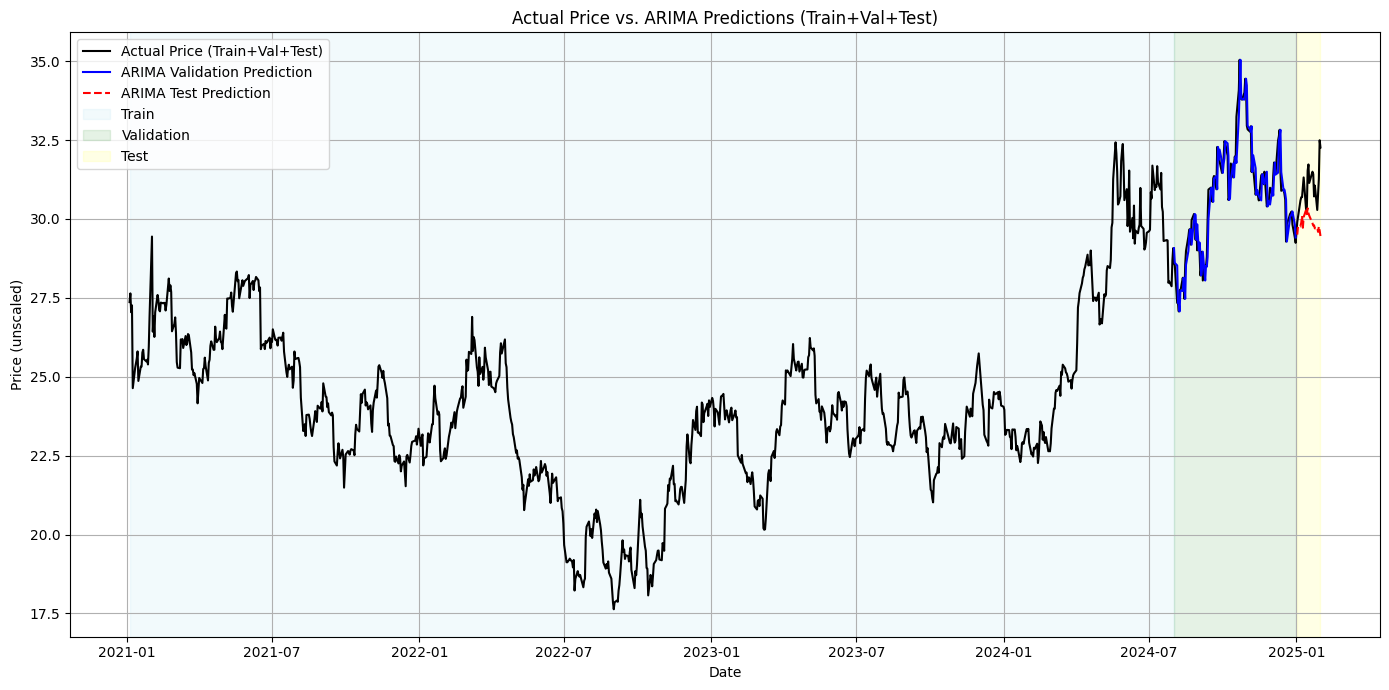

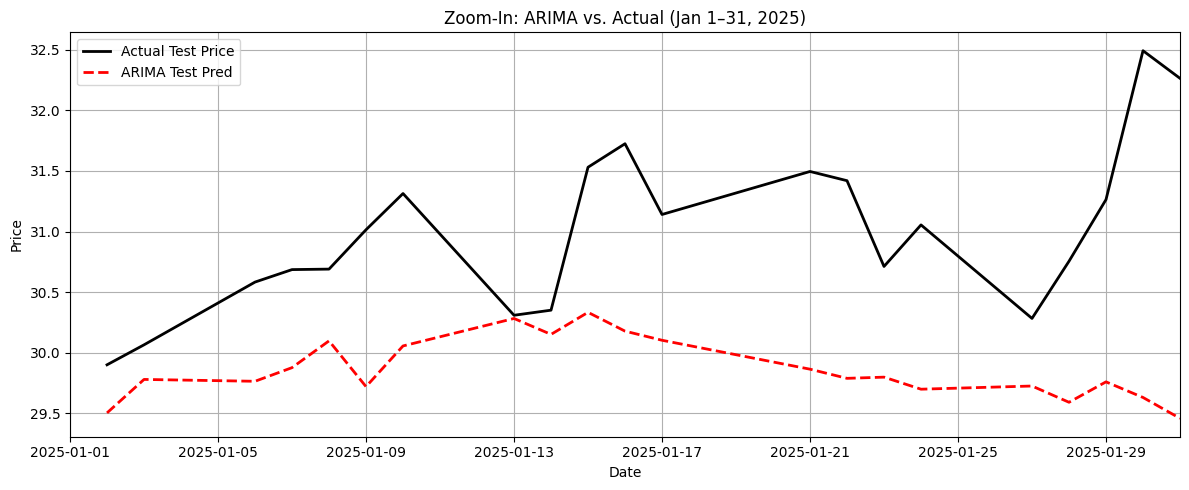

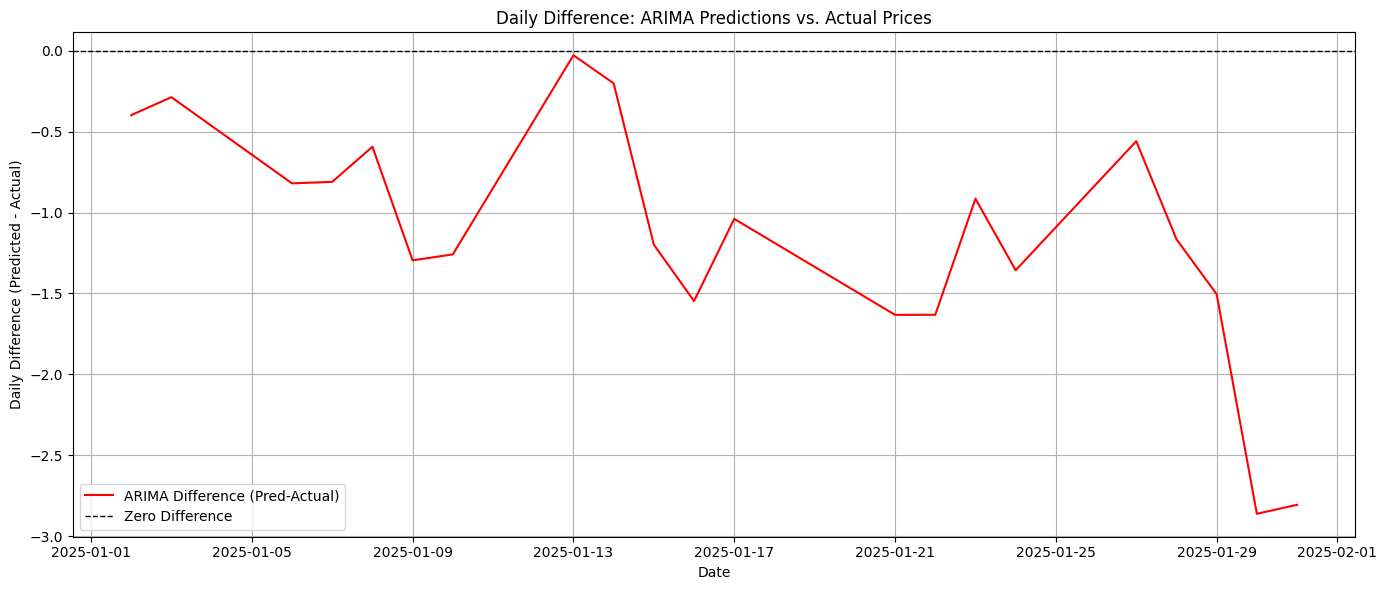

Polynomial-fitting test DataFrame columns: ['Date', 'Actual', 'ARIMA']
Number of rows in polynomial-fitting test DataFrame: 21

=== Best Polynomial Orders (Test Window) ===
[Actual] -> Best Degree: 33, Val MSE = 0.196528
     Polynomial Expression: y = 3.1306e-130*x^33+5.7268e-127*x^32-5.2944e-122*x^31-1.6228e-117*x^30-3.3030e-113*x^29-5.3272e-109*x^28-6.4770e-105*x^27-3.8701e-101*x^26+1.1066e-96*x^25+5.3698e-92*x^24+1.5450e-87*x^23+3.5944e-83*x^22+7.3665e-79*x^21+1.3457e-74*x^20+2.1904e-70*x^19+2.8363e-66*x^18+1.8197e-62*x^17-3.9173e-58*x^16-2.2837e-53*x^15-7.0772e-49*x^14-1.7832e-44*x^13-3.9486e-40*x^12-7.7481e-36*x^11-1.3630e-31*x^10-1.8924e-27*x^9-1.6456e-23*x^8+1.9813e-19*x^7+1.5442e-14*x^6+5.0809e-10*x^5+1.2593e-05*x^4+2.5026e-01*x^3+3.3065e+03*x^2-1.4261e+07*x-3.1924e+12

[ARIMA] -> Best Degree: 4, Val MSE = 0.025462
     Polynomial Expression: y = 2.8465e-09*x^4-1.1451e-04*x^3+6.7276e-04*x^2+4.6303e+04*x-4.6568e+08



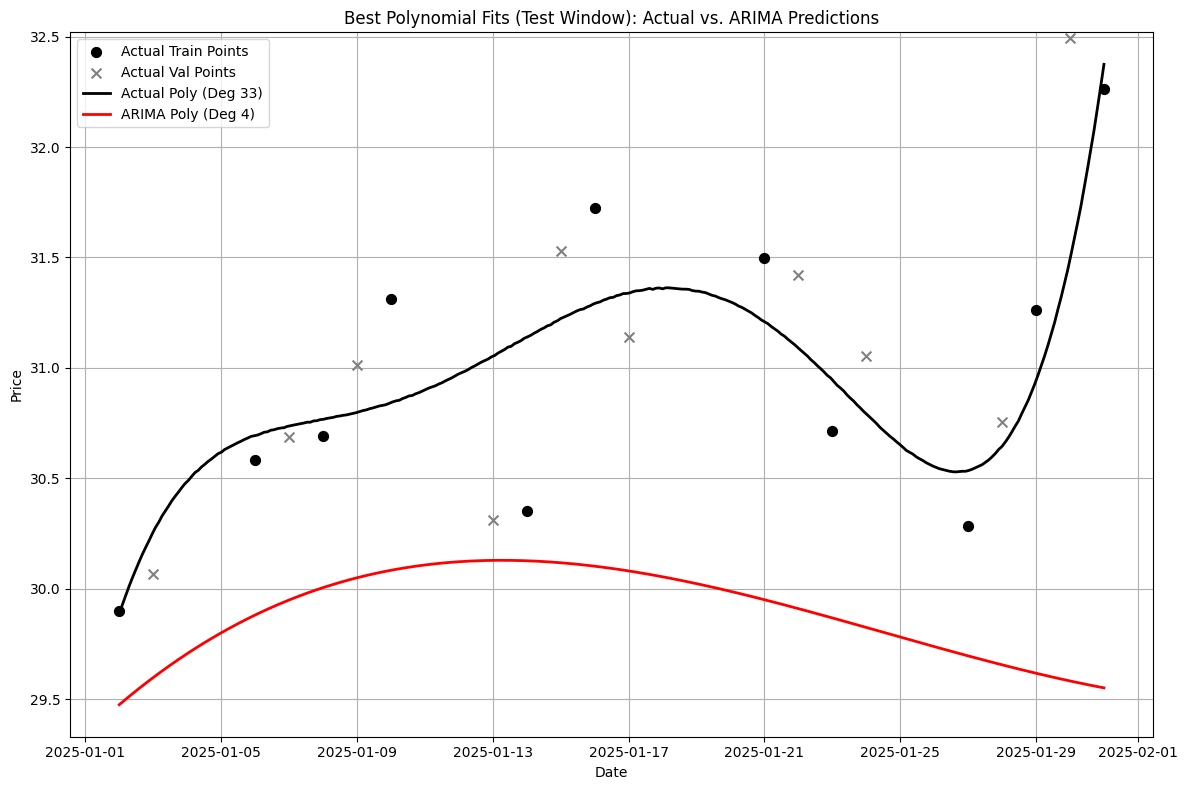

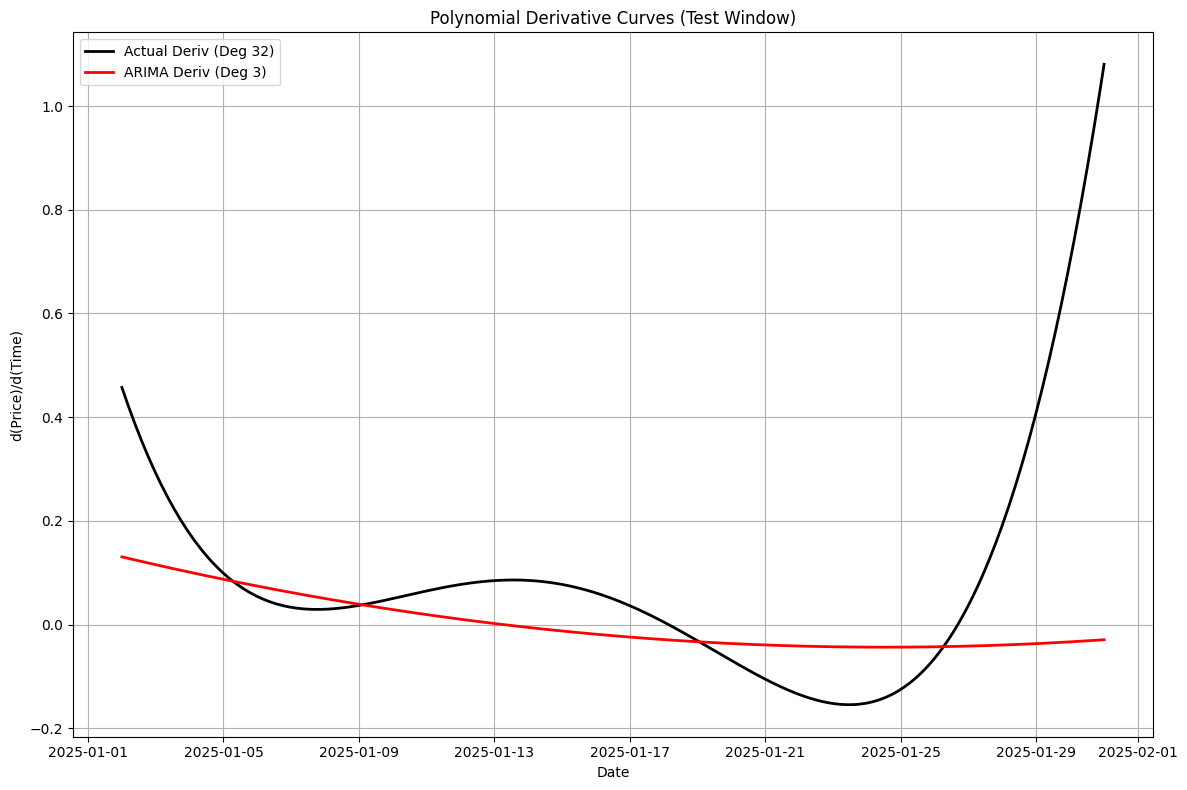


=== Derivative Polynomial Expressions ===
[Actual] (Degree 33) -> derivative: 1.0331e-128*x^32+1.8326e-125*x^31-1.6413e-120*x^30-4.8684e-116*x^29-9.5786e-112*x^28-1.4916e-107*x^27-1.7488e-103*x^26-1.0062e-99*x^25+2.7666e-95*x^24+1.2888e-90*x^23+3.5534e-86*x^22+7.9077e-82*x^21+1.5470e-77*x^20+2.6914e-73*x^19+4.1617e-69*x^18+5.1054e-65*x^17+3.0935e-61*x^16-6.2676e-57*x^15-3.4255e-52*x^14-9.9080e-48*x^13-2.3181e-43*x^12-4.7383e-39*x^11-8.5229e-35*x^10-1.3630e-30*x^9-1.7031e-26*x^8-1.3164e-22*x^7+1.3869e-18*x^6+9.2651e-14*x^5+2.5404e-09*x^4+5.0373e-05*x^3+7.5079e-01*x^2+6.6131e+03*x-1.4261e+07
[ARIMA] (Degree 4) -> derivative: 1.1386e-08*x^3-3.4353e-04*x^2+1.3455e-03*x+4.6303e+04


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib
from statsmodels.tsa.arima.model import ARIMA
import torch.backends.cudnn as cudnn
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

# ------------------------------------------------------------------------
# Suppress common warning messages for cleaner output
# ------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Let CuDNN pick the fastest algorithm for your hardware
cudnn.benchmark = True

# ------------------------------------------------------------------------
# 1. Set random seeds
# ------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------------------------------------------------------
# Global hyperparameters and file paths
# ------------------------------------------------------------------------
WINDOW_SIZE = 35
features = ["Price", "Open", "High", "Low"]

# (A) For training/validation/testing: partial CSV
csv_file_partial = "Silver Futures Historical Data.csv"
# (B) For final plotting and polynomial fitting: complete CSV with full timeline
csv_file_complete = "Silver Futures Historical Data_Complete.csv"

# ------------------------------------------------------------------------
# 2. Load & Clean the partial CSV (used for training/val/test)
# ------------------------------------------------------------------------
df = pd.read_csv(csv_file_partial)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("PARTIAL CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in partial df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ------------------------------------------------------------------------
# 4. Fit MinMaxScaler on TRAIN only
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

# ------------------------------------------------------------------------
# 5. Create Training Sequences (for pipeline consistency)
# ------------------------------------------------------------------------
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)
X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=len(train_dataset),  # single-batch approach
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4
)

# ------------------------------------------------------------------------
# 6. ARIMA Baseline Model Definition & Training Function
# ------------------------------------------------------------------------
from statsmodels.tsa.arima.model import ARIMA

class ARIMAModel(nn.Module):
    def __init__(self, order=(1,0,0), epsilon=1e-4):
        """
        ARIMA baseline model (univariate per feature).
        order: ARIMA order, e.g., (1,0,0) is AR(1).
        epsilon: threshold below which std is near-constant => fallback last value.
        """
        super().__init__()
        self.order = order
        self.epsilon = epsilon
        
    def forward(self, x):
        # x: shape (batch, window, features)
        batch_predictions = []
        for sample in x:
            sample_pred = []
            for feature_idx in range(sample.shape[1]):
                series = sample[:, feature_idx].detach().cpu().numpy()
                # If nearly constant => just return the last value
                if np.std(series) < self.epsilon:
                    forecast = series[-1]
                else:
                    try:
                        model = ARIMA(series, order=self.order)
                        model_fit = model.fit(disp=0)
                        forecast = model_fit.forecast(steps=1)[0]
                    except Exception:
                        # fallback if ARIMA fails
                        forecast = series[-1]
                sample_pred.append(forecast)
            batch_predictions.append(sample_pred)
        return torch.tensor(batch_predictions).float().to(x.device)

def train_model_arima():
    model = ARIMAModel(order=(1,0,0)).to(device)
    print("[ARIMA] ARIMA baseline model created.")
    return model

# ------------------------------------------------------------------------
# 7. Validation Predictions (Non-iterative)
# ------------------------------------------------------------------------
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy().sort_values("Date")
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ------------------------------------------------------------------------
# 8. Iterative Walk-Forward Test Predictions with Recursive Updates + Noise
# ------------------------------------------------------------------------
def iterative_walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE, noise_std=0.01):
    """
    In testing, when actual observations are no longer available,
    use the model's predicted values (with added Gaussian noise)
    as inputs for the next prediction.
    """
    df_work = df_all_scaled.copy().sort_values("Date")
    test_idx = df_work.index[df_work["Date"] >= test_start]
    if len(test_idx) == 0:
        raise ValueError("No test data available after test_start")
    first_test_idx = test_idx[0]
    # Current window uses real data for the last 'window' rows before test_start
    current_window = df_work.iloc[first_test_idx - window:first_test_idx][features].values
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    preds = []
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            noise = np.random.normal(scale=noise_std, size=pred_scaled.shape)
            pred_scaled_noisy = pred_scaled + noise
            preds.append((d, *pred_scaled_noisy))
            current_window = np.vstack((current_window[1:], pred_scaled_noisy))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

# ------------------------------------------------------------------------
# 9A. Overall Plot Using COMPLETE CSV for Actual Data
# ------------------------------------------------------------------------
def evaluate_and_plot(val_pred_df, test_pred_df, complete_csv=csv_file_complete):
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)
    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")
    df_complete.reset_index(drop=True, inplace=True)
    
    print("\nCOMPLETE CSV date range:")
    print("  Min date:", df_complete["Date"].min())
    print("  Max date:", df_complete["Date"].max())
    print("Number of rows in complete df:", len(df_complete))
    
    plt.figure(figsize=(14,7))
    plt.plot(df_complete["Date"], df_complete["Price"],
             color="black", label="Actual Price (Train+Val+Test)")
    
    if val_pred_df is not None and not val_pred_df.empty:
        plt.plot(val_pred_df["Date"], val_pred_df["Pred_Price_unscaled"],
                 color="blue", linestyle="-", label="ARIMA Validation Prediction")
    
    if test_pred_df is not None and not test_pred_df.empty:
        plt.plot(test_pred_df["Date"], test_pred_df["Pred_Price_unscaled"],
                 color="red", linestyle="--", label="ARIMA Test Prediction")
    
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, df_complete["Date"].max(), color="yellow", alpha=0.1, label="Test")
    
    plt.title("Actual Price vs. ARIMA Predictions (Train+Val+Test)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# 9B. Test Period Zoom-In (Jan 1 to Jan 31, 2025)
# ------------------------------------------------------------------------
def plot_test_period_zoom(test_pred_df, complete_csv=csv_file_complete):
    start_zoom = pd.to_datetime("2025-01-01")
    end_zoom   = pd.to_datetime("2025-01-31")
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)
    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")
    df_test_actual = df_complete[(df_complete["Date"] >= start_zoom) & (df_complete["Date"] <= end_zoom)].copy()
    
    if test_pred_df is not None and not test_pred_df.empty:
        test_pred_df_zoom = test_pred_df[(test_pred_df["Date"] >= start_zoom) & (test_pred_df["Date"] <= end_zoom)].copy()
    else:
        test_pred_df_zoom = pd.DataFrame()
    
    plt.figure(figsize=(12,5))
    if not df_test_actual.empty:
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color="black", linewidth=2, label="Actual Test Price")
    if not test_pred_df_zoom.empty:
        plt.plot(test_pred_df_zoom["Date"], test_pred_df_zoom["Pred_Price_unscaled"],
                 color="red", linestyle="--", linewidth=2, label="ARIMA Test Pred")
    
    plt.xlim([start_zoom, end_zoom])
    plt.title("Zoom-In: ARIMA vs. Actual (Jan 1–31, 2025)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# 9C. Daily Difference Diagram: ARIMA vs. Actual
# ------------------------------------------------------------------------
def plot_daily_difference_arima(test_pred_df, complete_csv=csv_file_complete):
    """
    Plots the daily difference (Predicted - Actual) for the entire test period.
    """
    if test_pred_df is None or test_pred_df.empty:
        print("[Daily Diff] No test predictions to plot.")
        return
    
    # Load the complete CSV for actual data
    df_complete = pd.read_csv(complete_csv)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)
    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")
    
    # Merge the ARIMA test predictions with the actual test data
    df_merge = pd.merge(
        test_pred_df[["Date","Pred_Price_unscaled"]],
        df_complete[["Date","Price"]],
        on="Date", how="inner"
    )
    df_merge.sort_values("Date", inplace=True)
    if df_merge.empty:
        print("[Daily Diff] No overlapping dates found for test predictions.")
        return
    
    # Compute the difference
    df_merge["Difference"] = df_merge["Pred_Price_unscaled"] - df_merge["Price"]
    
    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(df_merge["Date"], df_merge["Difference"], color="red", label="ARIMA Difference (Pred-Actual)")
    plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Difference")
    plt.xlabel("Date")
    plt.ylabel("Daily Difference (Predicted - Actual)")
    plt.title("Daily Difference: ARIMA Predictions vs. Actual Prices")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# 10. POLYNOMIAL FITTING on ARIMA Predictions (Trading Algorithm Part)
# ------------------------------------------------------------------------
# We'll define a helper function to run polynomial fitting
# and print the derivative expressions. We'll call it from main after predictions.
def run_polynomial_fitting_on_arima(test_pred_df):
    """
    1) Merge the ARIMA predictions with the complete CSV (actual),
       building a DataFrame for the test period.
    2) Fit polynomials (degree 1..65) on 'Actual' and 'ARIMA'.
    3) Plot best-fitting polynomial curves and derivative expressions.
    """
    if test_pred_df is None or test_pred_df.empty:
        print("[Polynomial] No test predictions available. Skipping polynomial fitting.")
        return
    
    # Load complete CSV for actual data
    df_complete = pd.read_csv(csv_file_complete)
    df_complete.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    df_complete["Date"] = pd.to_datetime(df_complete["Date"], errors="coerce")
    df_complete.sort_values("Date", inplace=True)
    for col in features:
        if col not in df_complete.columns:
            df_complete[col] = np.nan
        else:
            df_complete[col] = df_complete[col].astype(str).str.replace(",", "", regex=True)
            df_complete[col] = pd.to_numeric(df_complete[col], errors="coerce")
    df_complete.reset_index(drop=True, inplace=True)
    
    # Build DataFrame with 'Actual' and 'ARIMA' columns
    df_test_poly = df_complete[["Date","Price"]].rename(columns={"Price":"Actual"}).copy()
    df_test_poly.sort_values("Date", inplace=True)
    
    # Merge ARIMA predictions
    test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
    df_test_poly = pd.merge(
        df_test_poly,
        test_pred_df[["Date","Pred_Price_unscaled"]],
        on="Date", how="left"
    )
    df_test_poly.rename(columns={"Pred_Price_unscaled":"ARIMA"}, inplace=True)
    df_test_poly.dropna(axis=0, how="any", inplace=True)
    df_test_poly.reset_index(drop=True, inplace=True)
    
    if df_test_poly.empty:
        print("[Polynomial] Merged test DataFrame is empty. Skipping polynomial fitting.")
        return
    
    print("Polynomial-fitting test DataFrame columns:", df_test_poly.columns.tolist())
    print("Number of rows in polynomial-fitting test DataFrame:", len(df_test_poly))
    
    # Even-index rows for training, odd-index for validation
    n_points = len(df_test_poly)
    indices = np.arange(n_points)
    training_mask = (indices % 2 == 0)
    validation_mask = ~training_mask
    
    # Convert date to numeric
    df_test_poly["mdates_num"] = mdates.date2num(df_test_poly["Date"])
    
    def format_polynomial(coeffs):
        terms = []
        degree = len(coeffs) - 1
        for i, c in enumerate(coeffs):
            power = degree - i
            if power > 1:
                terms.append(f"{c:+.4e}*x^{power}")
            elif power == 1:
                terms.append(f"{c:+.4e}*x")
            else:
                terms.append(f"{c:+.4e}")
        expr = "".join(terms).replace("+-","-")
        return expr.lstrip("+")
    
    columns_to_fit = ["Actual","ARIMA"]
    best_poly_info = {}
    poly_degree_candidates = range(1,66)
    
    from sklearn.metrics import mean_squared_error
    
    # Fit polynomials
    for col in columns_to_fit:
        x_train = df_test_poly.loc[training_mask,"mdates_num"].values
        y_train = df_test_poly.loc[training_mask, col].values
        x_val   = df_test_poly.loc[validation_mask,"mdates_num"].values
        y_val   = df_test_poly.loc[validation_mask, col].values
        
        best_val_mse = float("inf")
        best_degree = None
        best_coeffs = None
        for d in poly_degree_candidates:
            coeffs = np.polyfit(x_train, y_train, d)
            y_val_pred = np.polyval(coeffs, x_val)
            val_mse = mean_squared_error(y_val, y_val_pred)
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_degree = d
                best_coeffs = coeffs
        best_poly_info[col] = {"degree":best_degree, "coeffs":best_coeffs, "val_mse":best_val_mse}
    
    # Print best polynomial info
    print("\n=== Best Polynomial Orders (Test Window) ===")
    for col in columns_to_fit:
        info = best_poly_info[col]
        deg = info["degree"]
        mse = info["val_mse"]
        coeffs = info["coeffs"]
        expr = format_polynomial(coeffs)
        print(f"[{col}] -> Best Degree: {deg}, Val MSE = {mse:.6f}")
        print(f"     Polynomial Expression: y = {expr}\n")
    
    # Plot best-fitting polynomials
    plt.figure(figsize=(12,8))
    # Plot actual training/validation points
    plt.scatter(df_test_poly.loc[training_mask,"Date"], df_test_poly.loc[training_mask,"Actual"],
                color="black", marker="o", s=50, label="Actual Train Points", zorder=5)
    plt.scatter(df_test_poly.loc[validation_mask,"Date"], df_test_poly.loc[validation_mask,"Actual"],
                color="gray", marker="x", s=50, label="Actual Val Points", zorder=5)
    
    colors = {"Actual":"black","ARIMA":"red"}
    x_dense = np.linspace(df_test_poly["mdates_num"].min(), df_test_poly["mdates_num"].max(), 300)
    x_dense_dates = [mdates.num2date(xx) for xx in x_dense]
    
    for col in columns_to_fit:
        info = best_poly_info[col]
        coeffs = info["coeffs"]
        y_dense = np.polyval(coeffs, x_dense)
        plt.plot(x_dense_dates, y_dense, color=colors[col], linewidth=2,
                 label=f"{col} Poly (Deg {info['degree']})")
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Best Polynomial Fits (Test Window): Actual vs. ARIMA Predictions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot derivative curves
    def derivative_expression(coeffs):
        d_coeffs = np.polyder(coeffs)
        return format_polynomial(d_coeffs)
    
    plt.figure(figsize=(12,8))
    for col in columns_to_fit:
        info = best_poly_info[col]
        coeffs = info["coeffs"]
        d_coeffs = np.polyder(coeffs)
        y_deriv = np.polyval(d_coeffs, x_dense)
        plt.plot(x_dense_dates, y_deriv, color=colors[col], linewidth=2,
                 label=f"{col} Deriv (Deg {info['degree']-1})")
    plt.xlabel("Date")
    plt.ylabel("d(Price)/d(Time)")
    plt.title("Polynomial Derivative Curves (Test Window)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print("\n=== Derivative Polynomial Expressions ===")
    for col in columns_to_fit:
        d_expr = derivative_expression(best_poly_info[col]["coeffs"])
        print(f"[{col}] (Degree {best_poly_info[col]['degree']}) -> derivative: {d_expr}")

# ------------------------------------------------------------------------
# 11. MAIN
# ------------------------------------------------------------------------
if __name__ == "__main__":
    print("\n=== Training & Predicting with ARIMA, plus Polynomial Fitting & Difference Diagram ===")
    # 1) Train ARIMA using partial CSV
    model = train_model_arima()
    
    # 2) Validation predictions
    val_pred_df = half_blind_validation_preds_df(
        model,
        df_scaled,
        val_start=train_cutoff,
        val_end=val_cutoff,
        window=WINDOW_SIZE
    )
    
    # 3) Test predictions (iterative walk-forward)
    test_pred_df = iterative_walk_forward_test(
        model,
        df_all_scaled=df_scaled,
        test_start=test_cutoff,
        window=WINDOW_SIZE,
        noise_std=0.01
    )
    
    # 4) Plot overall predictions using complete CSV for actual data
    evaluate_and_plot(val_pred_df, test_pred_df, complete_csv=csv_file_complete)
    
    # 5) Zoom-in on test period (Jan 1–31, 2025)
    plot_test_period_zoom(test_pred_df, complete_csv=csv_file_complete)
    
    # 6) Plot daily difference (Predicted - Actual)
    plot_daily_difference_arima(test_pred_df, complete_csv=csv_file_complete)
    
    # 7) Polynomial Fitting on ARIMA Predictions (test period)
    run_polynomial_fitting_on_arima(test_pred_df)
